# Causality-Aware Graph Neural Networks

## Prerequisites

First, we need to set up our Python environment that has PyTorch, PyTorch Geometric and PathpyG installed. Depending on where you are executing this notebook, this might already be (partially) done. E.g. Google Colab has PyTorch installed by default so we only need to install the remaining dependencies. The DevContainer that is part of our GitHub Repository on the other hand already has all of the necessary dependencies installed. 

In the following, we install the packages for usage in Google Colab using Jupyter magic commands. For other environments comment in or out the commands as necessary. For more details on how to install `pathpyG` especially if you want to install it with GPU-support, we refer to our [documentation](https://www.pathpy.net/dev/getting_started/). Note that `%%capture` discards the full output of the cell to not clutter this tutorial with unnecessary installation details. If you want to print the output, you can comment `%%capture` out.

In [ ]:
%%capture
!pip install torch
!pip install torch_geometric
!pip install git+https://github.com/pathpy/pathpyG.git

## Motivation and Learning Objectives

In previous tutorials, we have introduced causal paths in temporal graphs, and how we can use them to generate higher-order De Bruijn graph models that capture temporal-topological patterns in time series data. In this tutorial, we will show how we can use De Bruijn Graph Neural Networks, a causality-aware deep learning architecture for temporal graph data. The details of this approach are introduced [in this paper](https://proceedings.mlr.press/v198/qarkaxhija22a.html). The architecture is implemented in pathpyG and can be readily applied to temporal graph data. 

Below we illustrate this mthod in a supervised node classification task, i.e. given a temporal graph we will use the temporal-topological patterns in the graph to classify nodes.

We start by importing a few modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import torch
from torch_geometric.transforms import RandomNodeSplit

from sklearn.metrics import balanced_accuracy_score
from sklearn.manifold import TSNE

import pathpyG as pp
from pathpyG.nn.dbgnn import DBGNN

pp.config['torch']['device'] = 'cpu'
device = pp.config['torch']['device']

## Temporal-Topological Clusters in Temporal Graphs

Let us load a small synthetic toy example for a temporal graph with 60.000 time-stamped interactions between 30 nodes. We use the `TemporalGraph` class to load this example from a file containing edges with discrete time-stamps.

In [ ]:
t = pp.TemporalGraph.from_csv('../data/temporal_clusters.tedges')

This example has created in such a way that the nodes naturally form three clusters, which are highlighted in the interactive visualization below:

In [ ]:
style = {}
style['node_color'] = ['green']*10+['red']*10+['blue']*10
pp.plot(t, **style, edge_size=10);

## Modelling Causal Structures with Higher-Order De Bruijn Graphs

But what is the origin for the cluster pattern? In the visualization above, you will notice that the time-stamped edges randomly interconnect nodes within and across clusters, actually there is no correlation whatsoever between the topology of links and the cluster membership of the nodes. Hence, the notion of clusters does not correspond to the common idea of cluster patterns in static graphs, which we can highlight further by plotting the static time-aggregated network:

In [ ]:
pp.plot(t.to_static_graph(), **style, edge_size=1, edge_color='gray');

In fact, the topology of this graph corresponds to that of a random graph, i.e. there are not patterns whatsoever in the topology of links. Nevertheless, the temporal graph contains a cluster pattern in the topology of causal or time-respecting paths. In particular, the temporal ordering of time-stamped edges is such that nodes with the same cluster label are more frequently connected by time-respecting paths than nodes with different cluster labels. Hence, nodes within the same clusters can more strongly influence each other in a causal way, i.e. via multiple interactions that follow the arrow of time. 

Traditional (temporal) graph neural networks will not be able to learn from this pattern, as it is due to the specific microscopic temporal ordering of edges. Using higher-order De Bruijn graph models implemented in pathpyG, we can learn from temporal graph data that contains such patterns. Let us explain this step by step.

Referring to the previous tutorial on causal paths in temporal graphs, we first create a node-time directed acyclic graph that captures the causal structure of the temporal graph. In this small example, we will only consider two time-stamped edges $(u,v;t)$ and $(v,w;t')$ to contribute to a causal path iff $0 < t'-t \leq 1$, i.e. we use a delta for the maximum time difference of one time step.

In [ ]:
m = pp.MultiOrderModel.from_temporal_graph(t, max_order=2)
print(m)

We can get the first and second order networks from the Multi Order Network object. The first order network is the network of nodes and edges, while the second order network is the network of first order edges as second order nodes and second order edges. The second order network is a De Bruijn graph that captures the temporal-topological patterns in the data.

In [ ]:
g = m.layers[1]
g2 = m.layers[2]

In [ ]:
pp.plot(g, edge_size=2);

Since it does not consider patterns in the causal topology of the temporal graph, this is not a meaningful model. We can instead use a second-order De Bruijn graph model, which we can easily fit to the paths:

In [ ]:
pp.plot(g2, edge_size=1);

In this graph, every node is a link and links correspond to causal paths of length two, i.e. temporally ordered sequences consisting of two edges that overlap in the center node. In this graph, we clearly see a cluster pattern that is due to the way in which temporal edges are ordered in time. In particular, we see three clusters, where the edges in three of the clusters correspond to causal paths of length two that connect nodes within each of the three clusters. The edges in the fourth cluster (in the center of the visualization) represent causal paths that connect nodes in different clusters.

## Comparison to Temporal Graph with Shuffled Time Stamps

You may wonder whether this pattern is really due to the temporal ordering of time-stamped edges. It is easy to check this. We can simply randomly shuffle the time stamps of all edges, which will break any correlations in the temporal ordering that lead to patterns in the causal topology.

We repeat the path calculation for this shuffled temporal graph and construct the second-order De Bruijn Graph model again:

In [ ]:
t_shuffled = pp.TemporalGraph.from_csv('../data/temporal_clusters.tedges')
t_shuffled.shuffle_time()

In [ ]:
g2_shuffled = pp.MultiOrderModel.from_temporal_graph(t_shuffled, max_order=2).layers[2]

In [ ]:
pp.plot(g2_shuffled);

We now find that the cluster pattern in the second-order graph has vanished. In fact, there is no pattern whatsoever since the underlying (static) graph topology is random and the random shuffling of time stamps leads to random causal paths. 

## Spectral clustering with second-order graph Laplacian

To take a different perspective on cluster patterns, we can actually use `pathpyG` to apply a spectral analysis to the higher-order graph. We can simply calculate a generalization of the Laplacian matrix to the second-order graph both for the actual temporal graph and its shuffled counterpart: 

In [ ]:
L = g2.get_laplacian(normalization='rw', edge_attr='edge_weight')
L_shuffled= g2_shuffled.get_laplacian(normalization='rw',edge_attr='edge_weight')

We then calculate the eigenvalues and eigenvectors of the Laplacians, and compute the Fiedler vector, i.e. the eigenvector that corresponds to the second-smallest eigenvalue of the Laplacian.

In [ ]:
w,v = sp.linalg.eig(L.todense(),left= False, right = True)
w_shuffled, v_shuffled = sp.linalg.eig(L_shuffled.todense())

In [ ]:
fiedler = v[:,np.argsort(w)[1]]
fiedler_shuffled = v_shuffled[:,np.argsort(w_shuffled)[1]]

Below, we show that the clusters in the causal topology of the temporal graph correspond to clusters in the distribution of entries in the Fiedler vector, while there is no such pattern for the Fiedler vector of the second-order graph constructed from the shuffled temporal graph:

In [ ]:
c = []
a = []
for v in g2.nodes:
    if int(v[0])<10 and int(v[1])<10:
        c.append('green')
        a.append(1)
    elif int(v[0])<20 and int(v[0])>= 10 and int(v[1])<20 and int(v[1])>=10: 
        c.append('red')
        a.append(1)
    elif int(v[0])<30 and int(v[0])>= 20 and int(v[1])<30 and int(v[1])>=20:
        c.append('blue')
        a.append(1)
    else:
        c.append('black')
        a.append(0.1)

In [ ]:
c_shuffled = []
a_shuffled = []
for v in g2_shuffled.nodes: 

    if int(v[0])<10 and int(v[1])<10:
        c_shuffled.append('green')
        a_shuffled.append(1)
    elif int(v[0])<20 and int(v[0])>= 10 and int(v[1])<20 and int(v[1])>=10: 
        c_shuffled.append('red')
        a_shuffled.append(1)
    elif int(v[0])<30 and int(v[0])>= 20 and int(v[1])<30 and int(v[1])>=20:
        c_shuffled.append('blue')
        a_shuffled.append(1)
    else:
        c_shuffled.append('black')
        a_shuffled.append(0.1)

In the plots below, we have colored those entries of the Fiedler vectors that correspond to edges connecting nodes within one of the three clusters shown above. The Fiedler vector shows a clear pattern, which translates to the cluster pattern in the causal topology that we have planted into our synthetic temporal graph.

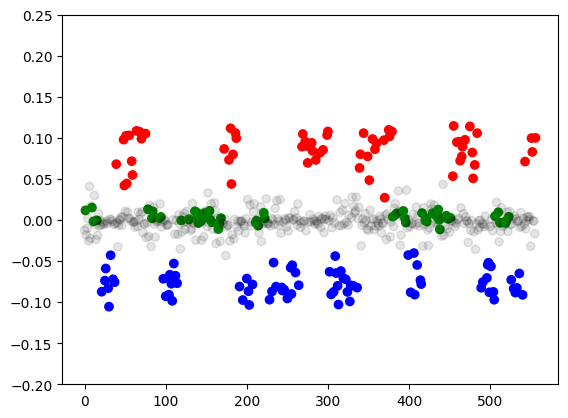

In [25]:
plt.ylim(-.2, .25)
plt.scatter(range(g2.N), np.real(fiedler),c=c, alpha=a);

No such pattern exists in the Fiedler vector of the second-order graph corresponding to the shuffled `TemporalGraph`. 

/opt/conda/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


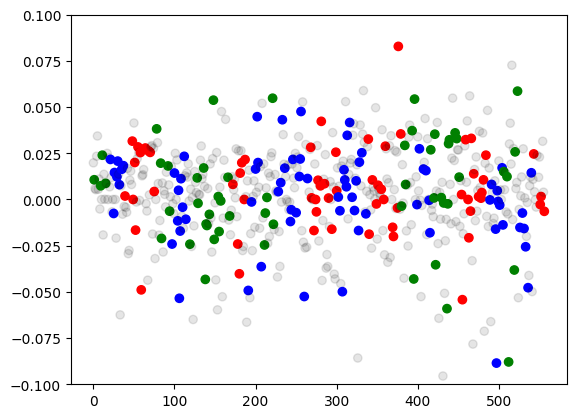

In [26]:
plt.ylim(-.1, .1)
plt.scatter(range(g2_shuffled.N), fiedler_shuffled, c=c_shuffled, alpha=a_shuffled);

## Node Classification with Causality-Aware Graph Neural Networks

Let us now explore how we can develop a causality-aware deep graph learning architecture that utilizes this pattern in the causal topology. We will follow the architecture introduced [in this work](https://proceedings.mlr.press/v198/qarkaxhija22a.html). The architecture actually performs message passing in higher-order models with multiple orders at once. In a final message passing step, a bipartite graph is used to obtain vector-space representations of actual nodes in the temporal graph. 

We now set up a `pytorch_geometric.Data` object that contains all of the information needed to train the DBGNN model.

We can use a convenience function of the `DBGNN` class in `pathpyG` to simplify this step.
Combining a first- and a second-order model, we use the edge indices and the weight tensors for our message passing scheme. We further construct an edge_index of a bipartite graph that uses the last node in a second-order node to map messages back to first-order nodes. 

In [27]:
data = m.to_dbgnn_data(max_order=2, mapping='last')
data.y = torch.tensor([ int(i) // 10 for i in t.mapping.node_ids])

## Training the model

We are now ready to train and evaluate our causality-aware graph neural network. We will frist create a random split of the nodes, set the optimizer and the hyperparameters of our model.

In [28]:
data = RandomNodeSplit(num_val=0, num_test=0.3)(data)

model = DBGNN(
        num_features =[g.N, g2.N],
        num_classes = len(data.y.unique()),
        hidden_dims = [16, 32, 8],
        p_dropout = 0.4
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(),  lr=0.005)
loss_function = torch.nn.CrossEntropyLoss()

data = data.to(device)

The following function evaluates the prediction of our model based on the balanced accuracy score for categorical predictions.

In [29]:
def test(model, data):
    model.eval()

    _, pred = model(data).max(dim=1)

    metrics_train = balanced_accuracy_score(
        data.y[data.train_mask].cpu(),
        pred[data.train_mask].cpu().numpy()
        )

    metrics_test = balanced_accuracy_score(
        data.y[data.test_mask].cpu(),
        pred[data.test_mask].cpu().numpy()
        )

    return metrics_train, metrics_test

In [30]:
losses = []
for epoch in range(100):
        output = model(data)
        loss = loss_function(output[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss)

        if epoch % 10 == 0:
                train_ba, test_ba = test(model, data)
                print(f'Epoch: {epoch}, Loss: {loss}, Train balanced accuracy: {train_ba}, Test balanced accuracy: {test_ba}')

Epoch: 0, Loss: 1.4545503854751587, Train balanced accuracy: 0.3703703703703704, Test balanced accuracy: 0.6666666666666666
Epoch: 10, Loss: 0.8029877543449402, Train balanced accuracy: 0.6666666666666666, Test balanced accuracy: 0.6666666666666666
Epoch: 20, Loss: 0.114255890250206, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 30, Loss: 0.0012156919110566378, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 40, Loss: 6.354074866976589e-05, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 50, Loss: 1.663187867961824e-05, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 60, Loss: 9.604646947991569e-06, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 70, Loss: 7.572494268970331e-06, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 80, Loss: 6.732382644258905e-06, Train balanced accuracy: 1.0, Test balanced accuracy: 1.0
Epoch: 90, Loss: 6.272589871514356e-06, Train balanced accuracy: 1.0,

# Latent space representation of edges

We can inspect the model by plotting a latent space representation of the edges generated by the second-order layer of our architecture.

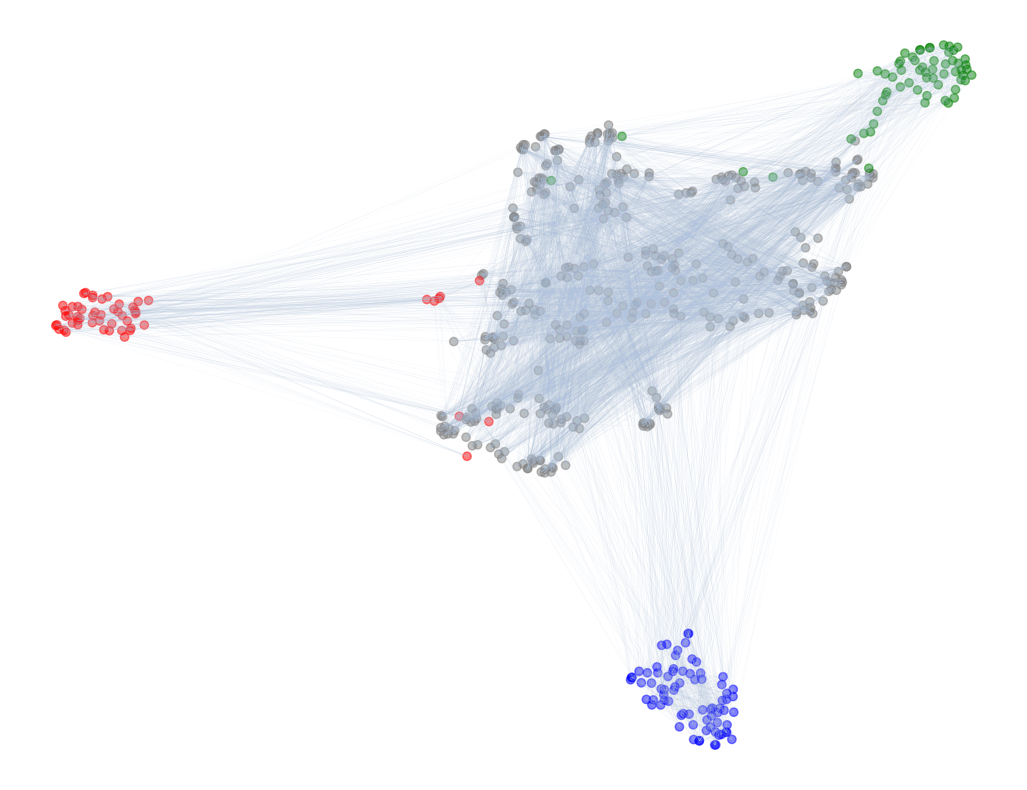

In [31]:
model.eval()
latent = model.higher_order_layers[0].forward(data.x_h, data.edge_index_higher_order).detach()
latent = model.higher_order_layers[1].forward(latent.cpu(), data.edge_index_higher_order).detach()
node_embedding = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(latent.cpu())

colors = []
for v, w in g2.nodes:
    if data.y[g.mapping.to_idx(v)] == 0 and data.y[g.mapping.to_idx(w)] == 0:
        colors.append('red')
    elif data.y[g.mapping.to_idx(v)] == 1 and data.y[g.mapping.to_idx(w)] == 1:
        colors.append('green')
    elif data.y[g.mapping.to_idx(v)] == 2 and data.y[g.mapping.to_idx(w)] == 2:
        colors.append('blue')
    else:
        colors.append('grey')

plt.figure(figsize=(13,10))
plt.scatter(node_embedding[:,0], node_embedding[:,1], c=colors, alpha=0.5)

for e in g2.edges:
    src = g2.mapping.to_idx(e[0])
    tgt = g2.mapping.to_idx(e[1])
    plt.plot([node_embedding[src,0], node_embedding[tgt,0]], [node_embedding[src,1], node_embedding[tgt,1]], 
             color='lightsteelblue', 
             linestyle='-', 
             alpha=0.2,
             lw=0.2)
plt.axis('off')
plt.show()

# Causality-aware latent space representation of nodes

We can further generate latent space representations of the nodes generated by the last bipartite layer of our architecture:

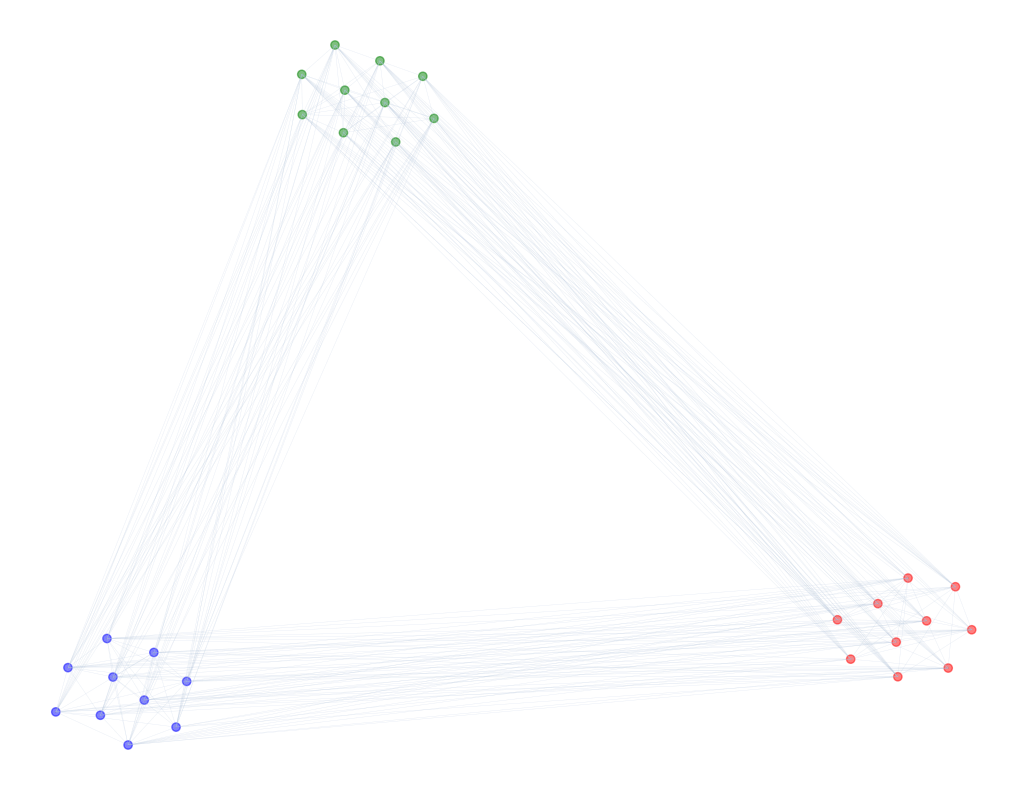

In [32]:
model.eval()
latent = model.forward(data).detach()
node_embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(latent.cpu())

colors = []
for v in g.nodes:
    if data.y[g.mapping.to_idx(v)] == 0:
        colors.append('red')
    elif data.y[g.mapping.to_idx(v)] == 1:
        colors.append('green')
    elif data.y[g.mapping.to_idx(v)] == 2:
        colors.append('blue')
    else:
        colors.append('grey')

plt.figure(figsize=(13,10))
plt.scatter(node_embedding[:,0], node_embedding[:,1], c=colors, alpha=0.5)

for e in g.edges:
    src = g.mapping.to_idx(e[0])
    tgt = g.mapping.to_idx(e[1])
    plt.plot([node_embedding[src,0], node_embedding[tgt,0]], [node_embedding[src,1], node_embedding[tgt,1]], 
             color='lightsteelblue', 
             linestyle='-', 
             alpha=0.2,
             lw=0.2)
plt.axis('off')
plt.show()